# Exoplanet Candidate Parameters: Exploratory Data Analysis

This notebook explores a subset of the **NASA Exoplanet Archive PSCompPars** table used in this project. The goal is to understand how key physical and observational parameters are distributed before we build models to predict whether a candidate is ultimately **confirmed** as an exoplanet (`target_confirmed`).

We focus on:

- The overall structure and completeness of the dataset  
- Distributions of core physical parameters such as orbital period, planet radius, and stellar temperature  
- High‑level patterns that may influence model performance and feature engineering

The EDA here is intentionally lightweight. The main objective is to sanity‑check the inputs to the modeling pipeline and document the assumptions behind the features we keep.

---

## 1. Loading and previewing the data

The first step is to load the processed PSCompPars extract used for modeling and inspect a small sample of rows.

Each row corresponds to a **planet candidate** with the following columns:

- `pl_name` – planet identifier from the archive  
- `pl_orbper` – orbital period in days  
- `pl_rade` – planet radius in Earth radii  
- `st_teff` – stellar effective temperature in Kelvin  
- `st_rad` – stellar radius in Solar radii  
- `sy_snum` – number of stars in the system  
- `sy_pnum` – number of planets in the system  
- `disc_year` – discovery year  
- `discoverymethod` – detection technique reported by the archive  
- `target_confirmed` – binary flag indicating whether the candidate is confirmed (`1`) or not (`0`)

The preview helps verify that the column types and value ranges look reasonable before moving on to summary statistics.


In [100]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("../data/raw/pscomppars_20251108.csv")  
df.head()

,pl_name,pl_orbper,pl_rade,st_teff,st_rad,sy_snum,sy_pnum,disc_year,discoverymethod,target_confirmed
0,Kepler-770 c,1.475323,5.880000,4941.00,4.88500,1.0,3.0,2016.0,Transit,1
1,2545.01,7.994037,2.557602,5846.29,1.25324,1.0,1.0,2016.0,Transit,0
2,1551.01,1.675460,6.448890,6745.50,1.78000,1.0,1.0,2016.0,Transit,0
3,Kepler-593 b,21.217090,2.600000,6191.00,1.00700,1.0,1.0,2016.0,Transit,1
4,Kepler-106 c,13.570783,2.640000,5854.00,1.01200,1.0,4.0,2014.0,Transit,1


---

## 2. Dataset overview

We next check the overall structure of the table using `df.info`, summary statistics, and a simple missing‑value check.

In [101]:
df.info()
df.describe(include="all").T.head(20)
df.isna().sum().sort_values(ascending=False).head(20)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10982 entries, 0 to 10981
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   pl_name           10982 non-null  object 
 1   pl_orbper         10982 non-null  float64
 2   pl_rade           10982 non-null  float64
 3   st_teff           10982 non-null  float64
 4   st_rad            10982 non-null  float64
 5   sy_snum           10982 non-null  float64
 6   sy_pnum           10982 non-null  float64
 7   disc_year         10982 non-null  float64
 8   discoverymethod   10982 non-null  object 
 9   target_confirmed  10982 non-null  int64  
dtypes: float64(7), int64(1), object(2)
memory usage: 858.1+ KB


pl_name             0
pl_orbper           0
pl_rade             0
st_teff             0
st_rad              0
sy_snum             0
sy_pnum             0
disc_year           0
discoverymethod     0
target_confirmed    0
dtype: int64

### 2.1 Key observations:

- The dataset contains **10,982 rows** and **10 columns**.  
- All selected columns are **complete** in this extract (no missing values in the features or target).  
- Numeric columns span several orders of magnitude, particularly orbital period and stellar temperature, which suggests that later transformations (for example, log scaling) may be helpful for certain models.

This quick structural pass confirms that the data is in a clean tabular form and ready for basic visualization and modeling.

---

## 3. Distributions of core physical parameters

To understand the scale and spread of the physical features, we plot histograms for:

- `pl_orbper`  
- `pl_rade`  
- `st_teff`

These features capture the planet’s orbit, size, and host‑star temperature. Together, they provide a compact physical description that is likely to be informative for distinguishing confirmed exoplanets from false positives or unconfirmed candidates.


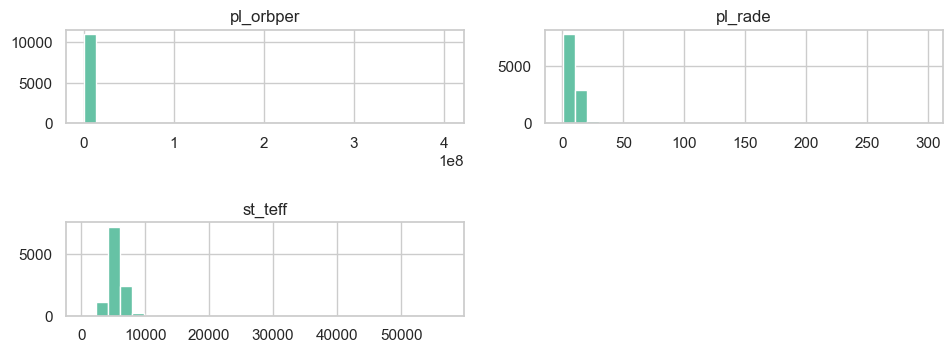

In [102]:
df[["pl_orbper", "pl_rade", "st_teff"]].hist(bins=30, figsize=(10, 4))
plt.tight_layout(pad=2)
plt.show()

### 3.1 Histogram interpretation:

At a glance, the histograms show:

- **Orbital period (`pl_orbper`)** is highly right‑skewed, with many short‑period planets and a tail of longer‑period systems. This is consistent with detection bias, where short‑period planets are easier to detect.  
- **Planet radius (`pl_rade`)** is concentrated at smaller sizes with a long tail toward larger gas giants. A log transform or binning scheme may make this distribution easier for models to learn from.  
- **Stellar temperature (`st_teff`)** clusters around Sun‑like stars but spans a broad range, indicating that the sample covers different spectral types.

These shapes hint at potential feature engineering steps, such as log scaling of orbital period or radius, or standardization of temperature for distance‑based models.


---

## 4. Target and categorical context

In the full analysis, we also examine:

- The class balance of `target_confirmed` (confirmed vs. not confirmed)  
- The distribution of `discoverymethod` and how heavily the sample is dominated by **Transit** detections  
- Trends in `disc_year`, which reflect improvements in instrumentation and survey strategies over time

These checks give context for the modeling task: a highly imbalanced target or a single dominant discovery method can influence how we evaluate performance and may motivate stratified splits or method‑specific analysis.


### 4.1 Class balance of the target

The target variable `target_confirmed` indicates whether a planet candidate is confirmed (`1`) or not (`0`).

A balanced target makes modeling easier and reduces the need for resampling.

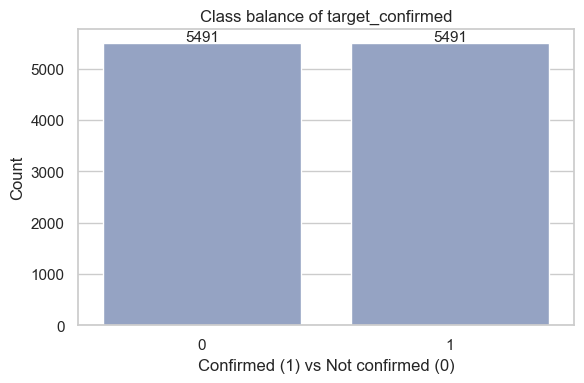

In [106]:
# Styling for all EDA plots 
sns.set_theme(
    style="whitegrid",   # light background with grid
    context="notebook",  # font sizes tuned for notebooks
    palette="Set2"       # soft qualitative color palette
)

# Class balance of target variable
plt.figure(figsize=(6, 4))

ax = sns.countplot(
    data=df,
    x="target_confirmed",
    color=sns.color_palette("Set2")[2]
)

plt.title("Class balance of target_confirmed")
plt.xlabel("Confirmed (1) vs Not confirmed (0)")
plt.ylabel("Count")

# Add bar labels
for p in ax.patches:
    ax.annotate(
        f"{int(p.get_height())}",
        (p.get_x() + p.get_width()/2, p.get_height()+50),
        ha="center", fontsize=11
    )

plt.tight_layout()
plt.show()

**This plot shows that the target classes are perfectly balanced. Confirmed and not confirmed candidates appear in equal numbers, which means the model will not suffer from class imbalance. This simplifies both training and evaluation since no resampling or class weighting is needed.**

### 4.2 Top discovery methods

Next, we look at the distribution of `discoverymethod` for the candidates in this modeling subset.

Shows which detection techniques dominate the sample. Strong skews may introduce method-specific bias.

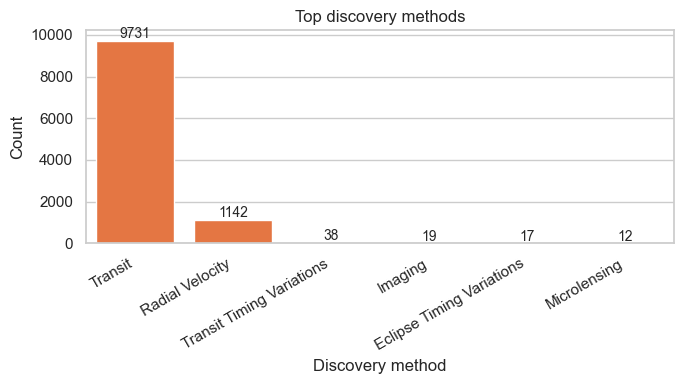

In [104]:
# Most common discovery methods
top_methods = (
    df["discoverymethod"]
    .value_counts()
    .head(6)
)

plt.figure(figsize=(7, 4))
ax = sns.barplot(
    x=top_methods.index,
    y=top_methods.values,
    color= "#ff6c28"
)

plt.title("Top discovery methods")
plt.xlabel("Discovery method")
plt.ylabel("Count")
plt.xticks(rotation=30, ha="right")

# Bar labels
for p, value in zip(ax.patches, top_methods.values):
    ax.annotate(
        f"{int(value)}",
        (p.get_x() + p.get_width()/2, value+100),
        ha="center", fontsize=10
    )

plt.tight_layout()
plt.show()

**Most discoveries in this subset were made using the Transit method, followed by Radial Velocity, with all other techniques contributing very small counts. This distribution reflects real observational bias: transit surveys like Kepler dominate the dataset. The imbalance is important context, since models may learn patterns tied to the survey technique rather than the underlying astrophysics.**

### 4.3 Discoveries by year
Finally, we examine how discoveries in this subset are distributed over `disc_year`.

Shows survey activity over time. Peaks usually line up with specific missions or instrument upgrades.

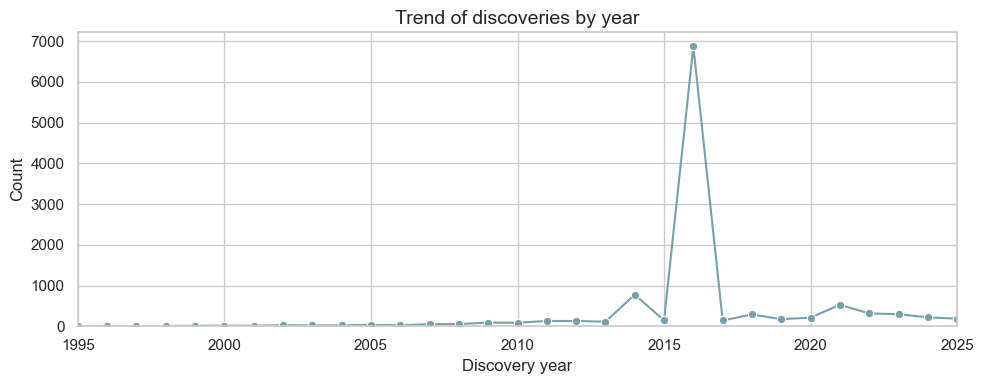

In [105]:
# Aggregate by year
year_counts = df["disc_year"].value_counts().sort_index()

plt.figure(figsize=(10, 4))
sns.set_style("whitegrid")

# line trend for readability
sns.lineplot(
    x=year_counts.index,
    y=year_counts.values,
    marker="o",
    color="#76a0ab"
)

plt.title("Trend of discoveries by year", fontsize=14)
plt.xlabel("Discovery year", fontsize=12)
plt.ylabel("Count", fontsize=12)

# focus on the active survey era
plt.xlim(1995, 2025)
plt.xticks(rotation=0)

# optional: tighten y-axis so the spike still fits but there is less empty space
plt.ylim(0, year_counts.max() * 1.05)

plt.tight_layout()
plt.show()

**The line trend highlights how strongly discoveries cluster in the Kepler and K2 mission era, with a sharp spike around 2015. Outside this period, discoveries occur at a much lower and steadier rate. This reinforces how exoplanet detection is driven by large survey missions and changes in instrumentation. It also explains the skew patterns seen in the physical parameters.**

---

## 5. Summary

This EDA provides a clear understanding of the modeling dataset and the observational context shaping it.

- The dataset is complete, with no missing values in the selected features or target.

- Physical parameters such as orbital period, planet radius, and stellar temperature show strong skew, consistent with astrophysical diversity and detection bias.

- The target classes are fully balanced, which removes the need for class reweighting or resampling during model training.

- Discovery methods and discovery years reveal strong survey-driven effects. Transit detections dominate the sample, and a major spike in discoveries aligns with the Kepler/K2 mission era. These patterns help explain feature distributions and highlight where bias may enter the model.

Overall, the dataset is well-structured for modeling. The visual checks confirm that the selected features are clean, interpretable, and aligned with the scientific context of the survey data. The next steps — feature engineering and model development — can proceed confidently using these insights as a guide.